## Task 1 : Quelles sont les 20 premières stations en terme de validations ?

In [2]:
import pandas as pd
validations = pd.read_csv('validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem.csv', sep=";")
stations = validations.groupby(['CODE_STIF_TRNS','CODE_STIF_RES','CODE_STIF_ARRET','LIBELLE_ARRET']).agg({'NB_VALD':sum})
top20_stations = stations.apply(lambda x: x.sort_values(ascending=False).head(20))
top20_stations

NB_VALD
CODE_STIF_TRNS CODE_STIF_RES CODE_STIF_ARRET LIBELLE_ARRET                    
800            854           822             SAINT-LAZARE             15538377
100            110           769             SAINT-LAZARE             14277916
810            801           393             LA DEFENSE-GRANDE ARCHE  12885594
                             163             CHATELET-LES HALLES      12553975
                             306             GARE DE LYON             11947650
100            110           562             MONTPARNASSE              8955968
800            853           308             GARE DU NORD              7792952
100            110           313             GARE DE L'EST             7569071
                             729             REPUBLIQUE                5485711
                             460             LES HALLES                5310315
800            850           305             GARE DE L'EST             4691588
100            110           165             CHATELET                  4117387
                             54              BASTILLE                  3866251
800            852           561             MONTPARNASSE              3778413
               805           343             HAUSSMANN-SAINT-LAZARE    3687795
100            110           60              BELLEVILLE                3655683
                             652             PLACE D'ITALIE            3650835
800            854           394             LA DEFENSE-GRANDE ARCHE   3631690
               853           815             SAINT-DENIS               3619397
100            110           352             HOTEL DE VILLE            3492316

## Task 2 : Proposez une illustration graphique de ce classement.

<AxesSubplot:title={'center':'Nombre de validations par station'}, xlabel='Stations', ylabel='Nbr Validations (Millions)'>

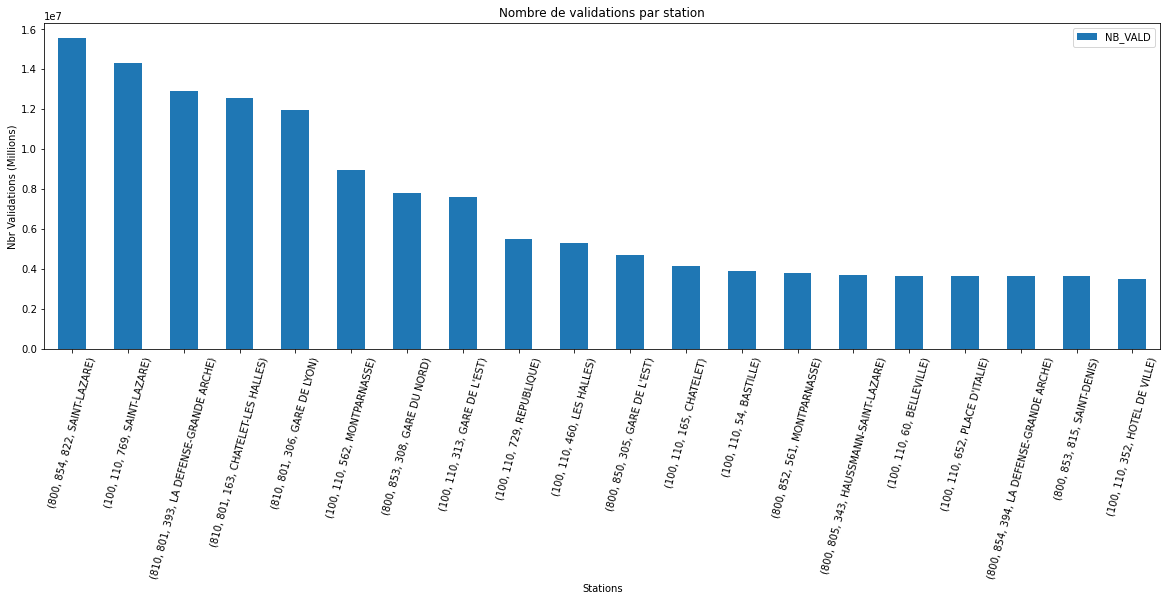

In [3]:
top20_stations.plot(kind='bar', title='Nombre de validations par station', ylabel='Nbr Validations (Millions)', xlabel='Stations', figsize=(20, 6), rot=75)

## Task 3 : Proposez une classification (partitionnement, clustering …) des arrêts en vous basant sur le nombre de validations par titre de transport

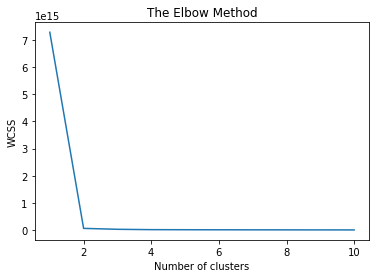

In [5]:

# Importing the libraries

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np

#Importing the mall dataset with pandas

dataset = pd.read_csv('validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem.csv', sep=";")

le = preprocessing.LabelEncoder()
for column_name in dataset.columns:
    if dataset[column_name].dtype == object:
        dataset[column_name] = le.fit_transform(dataset[column_name])
    else:
        pass
    
# Using the elbow method to find the optimal number of clusters

wcss =[]
for i in range (1,11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(dataset)
    wcss.append(kmeans.inertia_)

# Plot the graph to visualize the Elbow Method to find the optimal number of cluster  
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

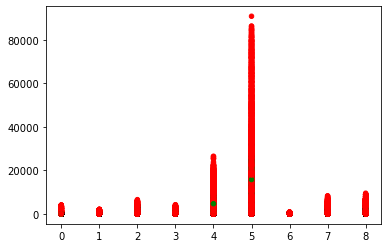

In [6]:
#Application de kmeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(dataset)

#visualisation

colormap = np.array(["Red","green"])
plt.scatter(dataset.CATEGORIE_TITRE,dataset.NB_VALD,c=colormap[kmeans.labels_],s=20)
plt.show()

## Task 4 : Trouver 10 paires de stations dont les noms sont proches.
### La solution est d'appliquer le Data matching en utilisant les concepts de ngram, TF-IDF avec consine similarity.

In [7]:
#  Importing libraries and module and some setting for notebook

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct  #Cosine Similarity
import time
pd.set_option('display.max_colwidth', -1)

# reading dataset

dataset = pd.read_csv('validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem.csv', sep=";")
X = dataset.iloc[:,[4]]

C:\Users\inf\AppData\Local\Temp\ipykernel_5556\3500601835.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [8]:
#  ngrams (n=3)
#  used for cleaning and removing some punctuation from a string 
#  and generate and collect all n-grams of the string.

def ngrams(string, n=3):

    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# calculate the similarity between two vectors of TF-IDF values the Cosine Similarity is usually used.
# result matrix in a very sparse terms and Scikit-learn deals with this nicely by returning a sparse CSR matrix.

def awesome_cossim_top(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)

    return csr_matrix((data,indices,indptr),shape=(M,N))

# unpacks the resulting sparse matrix

def get_matches_df(sparse_matrix, name_vector, top=100):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similairity': similairity})

In [ ]:
# After having each words split (token or  lemmas (n-gram generated items) ) into a vector and
# Scikit-learn’s  Tfidfvectorizer aim to do the same thing, which is to convert a collection of raw documents to a matrix of TF-IDF features. 
# Generate the matrix of TF-IDF (Term Frequency-Inverse Document frequency) values for each

libelle_arret = X['LIBELLE_ARRET']
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(libelle_arret)

In [ ]:
#  Run the optimized cosine similarity function. 
#  Only stores the top 10 most similar items with a similarity above 0.8

t1 = time.time()
matches = awesome_cossim_top(tf_idf_matrix, tf_idf_matrix.transpose(), 10, 0.8)
t = time.time()-t1
print("SELFTIMED:", t)

In [ ]:
# store the  matches into new dataframe called matched_df and printing 10 samples

matches_df = get_matches_df(matches, libelle_arret, top=200)
matches_df = matches_df[matches_df['similairity'] < 0.99999] # For removing all exact matches
matches_df.sample(10)